In [54]:
import os, sys, math, pickle, time
from zmqRemoteApi import RemoteAPIClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import randint as ri
from random import uniform as ru

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.losses import Huber
from keras.optimizers import Adam, SGD, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

### Funciones

In [2]:
#Function to split the training data into X,y datasets
def load_dataset(scene_in = "modular02a", date = "2023_21_12"):
    # Defining usefull variables
    path = os.getcwd() + "\\training\\training_data\\" + date
    file_list = os.listdir(path)
    scene_files_list = [item for item in file_list if scene_in in item and "pkl" in item]

    print(scene_files_list[0])
    file = open(path + "\\" + scene_files_list[0], "rb")
    training_data = pickle.load(file)
    training_df = pd.DataFrame(training_data)

    #List to store the name for every joint data column
    increments_columns = []
    prev_j_positions_columns = []
    post_j_positions_columns = []

    #Creates the name for every column
    num_joints = len(training_data[-1]["increments"])
    for joint_n in range(num_joints):
        #List to split inputs per joint
        joint_inc_col_name = "increments_" + str(joint_n)
        increments_columns.append(joint_inc_col_name)

        prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
        prev_j_positions_columns.append(prev_joint_pos_col_name)

        #List to split outputs per joint
        post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
        post_j_positions_columns.append(post_joint_pos_col_name)


    #Input columns per joint
    increments_df = pd.DataFrame(training_df['increments'].to_list())
    increments_df.columns = increments_columns


    prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
    prev_j_positions_df.columns = prev_j_positions_columns


    #Builds the X dataframe
    X_df = pd.concat([increments_df, prev_j_positions_df, 
                    training_df["prev_pos_x"], training_df["prev_pos_y"], training_df["prev_pos_z"]], 
                    axis="columns")


    #Output columns per joint
    post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
    post_j_positions_df.columns = post_j_positions_columns


    #Builds the y dataframe
    y_df = pd.concat([post_j_positions_df, 
                    training_df["post_pos_x"], training_df["post_pos_y"], training_df["post_pos_z"]], 
                    axis="columns")

    return(X_df,y_df)

In [3]:
def adapt_X_y(X_a,y_a):
    X_a_cols = ['current_state_x', 'current_state_y', 'current_state_z', 'joint0_current_state_rad', 'joint1_current_state_rad', 'joint2_current_state_rad'
                , 'joint0_actions_rad', 'joint1_actions_rad', 'joint2_actions_rad']

    X_a = pd.concat([X_a["prev_pos_x"], X_a["prev_pos_y"] , X_a["prev_pos_z"],
                X_a["prev_j_positions_0"], X_a["prev_j_positions_1"], X_a["prev_j_positions_2"],
                X_a["increments_0"], X_a["increments_1"], X_a["increments_2"]], 
                        axis="columns")

    X_a.columns = X_a_cols

    y_a_cols = ['future_state_x', 'future_state_y', 'future_state_z', 'joint0_future_state_rad', 'joint1_future_state_rad', 'joint2_future_state_rad']

    y_a = pd.concat([y_a["post_pos_x"], y_a["post_pos_y"] , y_a["post_pos_z"],
                y_a["post_j_positions_0"], y_a["post_j_positions_1"], y_a["post_j_positions_2"]], 
                        axis="columns")
    y_a.columns = y_a_cols
    return X_a, y_a

In [4]:
def plot_history(history, loss):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel(f'{loss} Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.legend()
  plt.show()

In [5]:
def plot_pred_vs_test(test, pred):
    columns = test.columns.tolist()
    max_list = []
    min_list = []
    mse_list = []
    perc_mse_list = []
    for column_num in range(len(columns)):
        plt.figure()
        plt.scatter(test.iloc[:,column_num], pred.iloc[:,column_num], s=1, color = "red")

        #Getting important values
        minim = min(test.iloc[:,column_num])
        min_list.append(minim)
        maxim = max(test.iloc[:,column_num])
        max_list.append(maxim)
        mse = mean_squared_error(test.iloc[:,column_num], pred.iloc[:,column_num])
        mse_list.append(round(mse,6))
        rang = (maxim-minim)
        perc = mse/rang *100
        perc_mse_list.append(round(perc,6))
        title = columns[column_num] + " - mse: " + str(round(mse,6))
        plt.title(title)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        # Para tener una linea recta con la cual comparar los valores y que no altere
        # los limites de la figura se grafican los valores reales con ellos mismos
        plt.plot(test.iloc[:,column_num],test.iloc[:,column_num])
        plt.grid()
    data = {"Perception": columns, "Max.": max_list, "Min.": min_list, "Mse": mse_list, "Mse perc.": perc_mse_list}
    data_df = pd.DataFrame(data)
    return(data_df)

In [78]:
# Grafica en español y unidades en ejes
def plot_pred_vs_test_clean(test, pred):
    columns = pred.columns.tolist()
    units = ["(m)", "(m)", "(m)", "(rad)", "(rad)", "(rad)"]
    max_list = []
    min_list = []
    mse_list = []
    perc_mse_list = []
    for column_num in range(len(columns)):
        plt.figure()
        plt.scatter(test.iloc[:,column_num], pred.iloc[:,column_num], s=1, color = "red")

        #Getting important values
        minim = min(test.iloc[:,column_num])
        min_list.append(minim)
        maxim = max(test.iloc[:,column_num])
        max_list.append(maxim)
        mse = mean_squared_error(test.iloc[:,column_num], pred.iloc[:,column_num])
        mse_list.append(round(mse,6))
        rang = (maxim-minim)
        perc = mse/rang *100
        perc_mse_list.append(round(perc,6))
        title = columns[column_num]
        plt.title(title)
        plt.xlabel('Valores reales ' + units[column_num])
        plt.ylabel('Predicción '+ units[column_num])
        # Para tener una linea recta con la cual comparar los valores y que no altere
        # los limites de la figura se grafican los valores reales con ellos mismos
        plt.plot(test.iloc[:,column_num],test.iloc[:,column_num])
        plt.grid()
    data = {"Percepción": columns, "Max.": max_list, "Min.": min_list, "Mse": mse_list, "Mse perc.": perc_mse_list}
    data_df = pd.DataFrame(data)
    return(data_df)

In [6]:
def export_model(exp_scene, exp_model, exp_scaler):
    timestr = time.strftime("_%Y_%d_%m")
    models_path = "models\\" + timestr[1:]
    if not os.path.exists(models_path):
        os.mkdir(models_path)
        print(f"Directorio '{models_path}' ha sido creado.")
    else:
        print(f"El directorio '{models_path}' ya existe.")
    exp_model.save(models_path + "\\model_" + exp_scene + timestr + ".keras")
    with open(models_path + "\\model_" + exp_scene + timestr + '.pkl', 'wb') as file:
        pickle.dump(exp_model, file)
    with open(models_path + "\\scaler_" + exp_scene + timestr + '.pkl', 'wb') as file:
        pickle.dump(exp_scaler, file)

### Modular03 90

In [7]:
scene = "modular03_90"
date = "2023_27_12"
X, y =load_dataset(scene,date)
X, y = adapt_X_y(X,y)
X

joined_training_dataset_modular03_90_2023_27_12_1040.pkl


,current_state_x,current_state_y,current_state_z,joint0_current_state_rad,joint1_current_state_rad,joint2_current_state_rad,joint0_actions_rad,joint1_actions_rad,joint2_actions_rad
0,0.154612,-8.080838e-06,0.158571,-0.785398,-0.785398,-0.785398,-1.321348,-1.471425,1.122269
1,0.086525,-4.221770e-06,0.020055,-1.570796,-1.570796,0.325748,-0.861672,0.124421,1.299778
2,0.115392,-3.920784e-06,0.051228,-1.570796,-1.457272,1.566681,-1.081271,-0.943161,-0.933913
3,0.094899,-4.583557e-06,0.024396,-1.570797,-1.570796,0.650146,-0.601830,1.105611,-1.072528
4,0.166384,-5.812245e-06,0.067092,-1.570797,-0.452730,-0.407958,-1.228446,-1.071737,-0.042537
...,...,...,...,...,...,...,...,...,...
119995,0.181224,9.411647e-06,0.135394,-1.570797,0.292095,-0.644915,1.394139,1.256591,0.043044
119996,-0.087196,2.591795e-06,0.235307,-0.149165,1.570554,-0.617199,1.015772,-0.936468,0.484063
119997,-0.168868,-2.877048e-06,0.179038,0.897353,0.651079,-0.146682,1.021707,-1.303959,-0.490774
119998,-0.148661,5.807086e-07,0.200975,1.570796,-0.669030,-0.630845,-1.404794,-0.978820,-0.102463


In [10]:
# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(96000, 9) (24000, 9)
(96000, 6) (24000, 6)


In [11]:
# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape

(96000, 9)

#### Combinaciones

Guardar los datos de cada combinacion

In [ ]:
combination_data = []

In [81]:
c1 ={"num": "1","capas": 1, "neuronas": 9, "taza": 0.001, "epochs": 30, "batch": 20}
c2 ={"num": "2","capas": 3, "neuronas": 27, "taza": 0.4, "epochs": 50, "batch": 32}

# Combinacion de hiperparametros numericos
c_num = c1

# Definicion de parametros numericos
capas = c_num["capas"]
neurons = c_num["neuronas"]
lr = c_num["taza"]
epochs_f = c_num["epochs"]
b_s = c_num["batch"]


cA ={"letter": "A", "activ": "linear", "optim": Adam(learning_rate=lr), "loss": Huber()}
cB ={"letter": "B", "activ": "sigmoid", "optim": SGD(learning_rate=lr), "loss": 'mean_squared_error'}
cC ={"letter": "C", "activ": "sigmoid", "optim": RMSprop(learning_rate=lr), "loss": 'mean_absolute_error'}
cD ={"letter": "D", "activ": "tanh", "optim": SGD(learning_rate=lr), "loss": Huber()}
cE ={"letter": "E", "activ": "tanh", "optim": Adam(learning_rate=lr), "loss": 'mean_squared_error'}
cF ={"letter": "F", "activ": "ReLU", "optim": RMSprop(learning_rate=lr), "loss": 'mean_squared_error'}
cF ={"letter": "G", "activ": "ReLU", "optim": Adam(learning_rate=lr), "loss": Huber()}

# Combinacion de hiperparametros cualitativos
c_cual = cB

# Definicion de parametros cualitativos
activation_f = c_cual["activ"]
optim = c_cual["optim"]
loss_f = c_cual["loss"]

c_data = []
combinacion = c_num["num"] + c_cual["letter"]
c_data.append(combinacion)

Dependiendo de la combinacion se crea la red

In [82]:
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=9, input_dim=9, activation=activation_f))

for layers in range(capas):
    # Capas ocultas
    model.add(Dense(units=neurons, activation=activation_f))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=6, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=optim, loss=loss_f)

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train, epochs=epochs_f, batch_size=b_s, validation_split=0.2)

Epoch 1/30
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6595 - val_loss: 0.6322
Epoch 2/30
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6345 - val_loss: 0.6304
Epoch 3/30
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6327 - val_loss: 0.6285
Epoch 4/30
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6308 - val_loss: 0.6266
Epoch 5/30
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6287 - val_loss: 0.6245
Epoch 6/30
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6265 - val_loss: 0.6222
Epoch 7/30
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6241 - val_loss: 0.6197
Epoch 8/30
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6216 - val_loss: 0.6170
Epoch 9/30
3840/3840 [==============================] - 4s 1ms/step - loss: 0.6187 - val_loss: 0.6140
Epoch 10/30
3840/3840 [==============================] - 4s 1ms/step - loss: 0.615

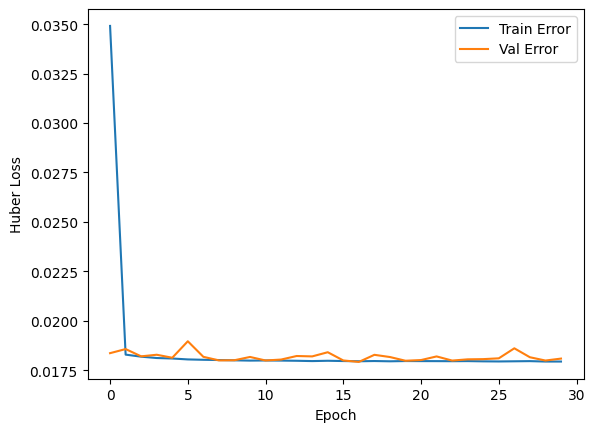

In [64]:
model.layers
plot_history(history, "Huber")

Combinacion: 1A
750/750 [==============================] - 1s 790us/step


,Percepción,Max.,Min.,Mse,Mse perc.
0,Posición en X,0.185844,-0.185979,0.003092,0.831685
1,Posición en Y,0.000035,-0.000089,0.000000,0.284259
2,Posición en Z,0.312063,0.018482,0.005302,1.806078
3,Posición articulación 1,1.570902,-1.570961,0.070776,2.252667
4,Posición articulación 2,1.570797,-1.570798,0.070824,2.254383
5,Posición articulación 3,1.570797,-1.570798,0.067642,2.153106


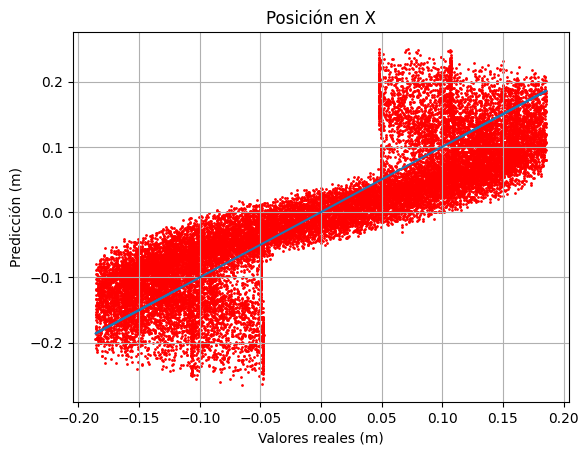

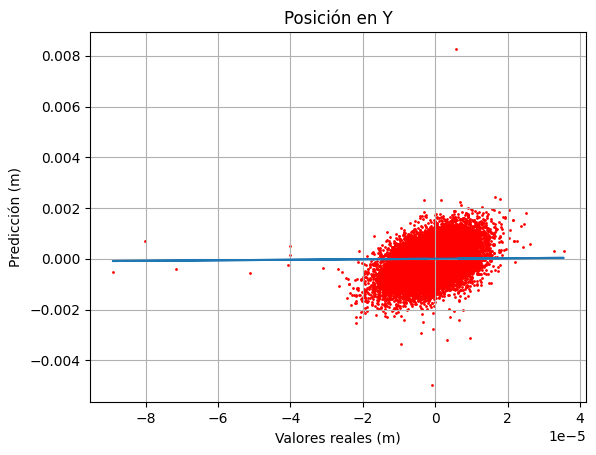

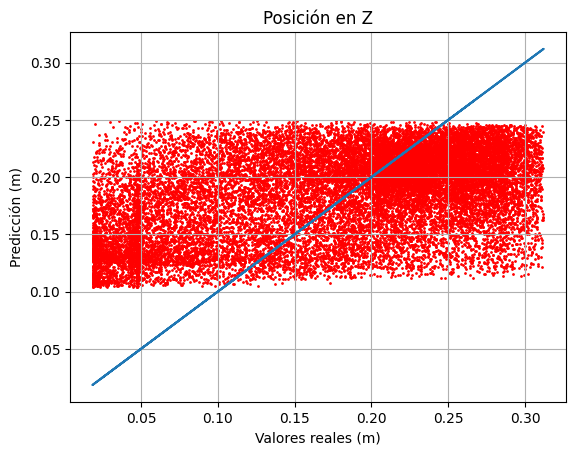

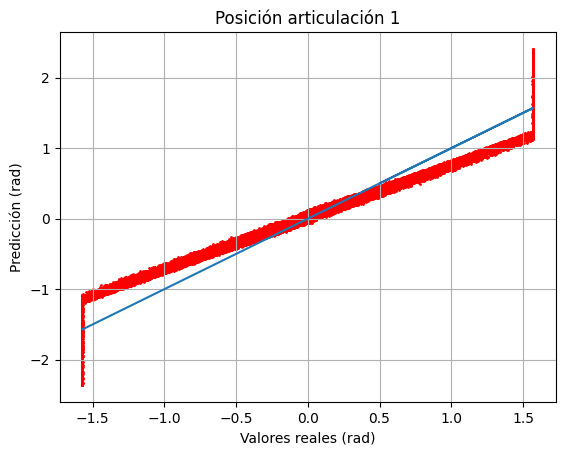

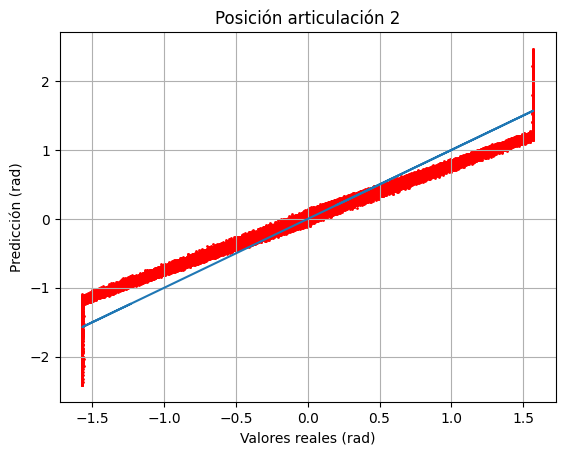

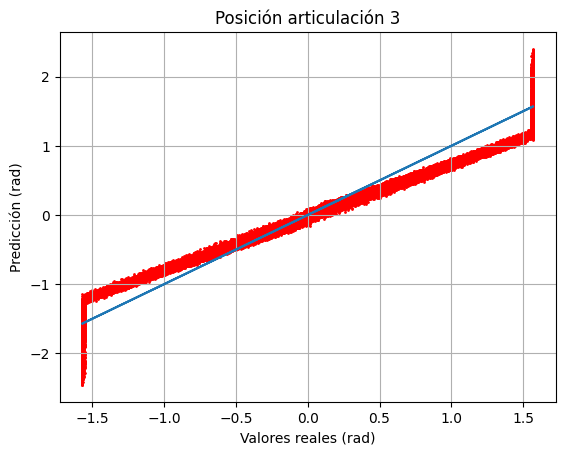

In [80]:
print("Combinacion:", combinacion)
## Finalmente se hace uso de los datos de prueba para la predicción.
plot_cols = ["Posición en X", "Posición en Y", "Posición en Z", "Posición articulación 1", "Posición articulación 2", "Posición articulación 3"]
test_predictions = model.predict(X_test_scaled)
df_test_predictions = pd.DataFrame(test_predictions)
df_test_predictions.columns = plot_cols
plot_pred_vs_test_clean(y_test, df_test_predictions)

In [ ]:
scene_name = scene + "_capasocultas_neuronascapa1_activacioncapa1__neuronascapa_n_activacioncapa1_n_optimizador_learningrate_perdida_epochs_batch_"
export_model(scene_name, model, scaler)

Directorio 'models\2023_21_12' ha sido creado.


### Modelo con menos epochs

In [57]:
model2 = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model2.add(Dense(units=9, input_dim=9, activation='linear'))

# Capas ocultas con 64 unidades cada una
model2.add(Dense(units=27, activation='relu'))

# Capas ocultas con 64 unidades cada una
#model2.add(Dense(units=27, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model2.add(Dense(units=6, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model2.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history2 = model2.fit(X_train_scaled, y_train, epochs=30, batch_size=20, validation_split=0.2)

Epoch 1/30
3840/3840 [==============================] - 5s 1ms/step - loss: 0.0226 - val_loss: 0.0051
Epoch 2/30
3840/3840 [==============================] - 4s 1ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 3/30
3840/3840 [==============================] - 4s 1ms/step - loss: 8.8252e-04 - val_loss: 5.0625e-04
Epoch 4/30
3840/3840 [==============================] - 4s 1ms/step - loss: 3.6949e-04 - val_loss: 2.9574e-04
Epoch 5/30
3840/3840 [==============================] - 5s 1ms/step - loss: 2.6180e-04 - val_loss: 2.1365e-04
Epoch 6/30
3840/3840 [==============================] - 5s 1ms/step - loss: 2.1438e-04 - val_loss: 1.9493e-04
Epoch 7/30
3840/3840 [==============================] - 4s 1ms/step - loss: 1.8721e-04 - val_loss: 1.6984e-04
Epoch 8/30
3840/3840 [==============================] - 4s 1ms/step - loss: 1.7019e-04 - val_loss: 1.8511e-04
Epoch 9/30
3840/3840 [==============================] - 4s 1ms/step - loss: 1.5886e-04 - val_loss: 1.7208e-04
Epoch 10/30
3840/3840 [===

750/750 [==============================] - 1s 778us/step


,Perception,Max.,Min.,Mse,Mse perc.
0,future_state_x,0.185844,-0.185979,0.000368,0.098891
1,future_state_y,0.000035,-0.000089,0.000000,0.192114
2,future_state_z,0.312063,0.018482,0.000302,0.102781
3,joint0_future_state_rad,1.570902,-1.570961,0.000164,0.005209
4,joint1_future_state_rad,1.570797,-1.570798,0.000307,0.009762
5,joint2_future_state_rad,1.570797,-1.570798,0.000247,0.007848


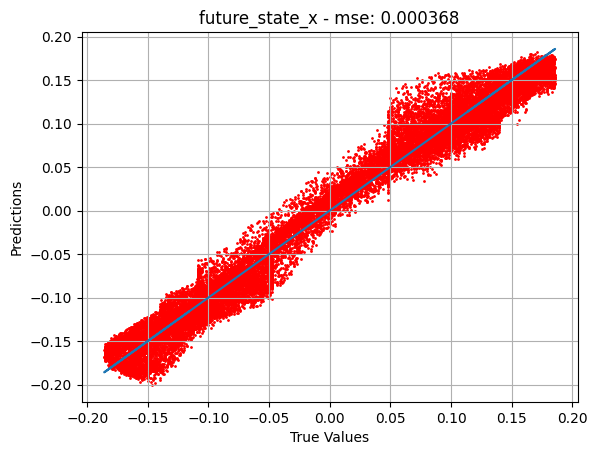

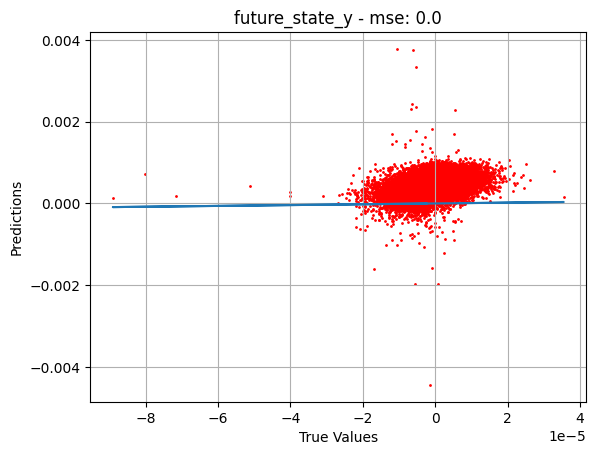

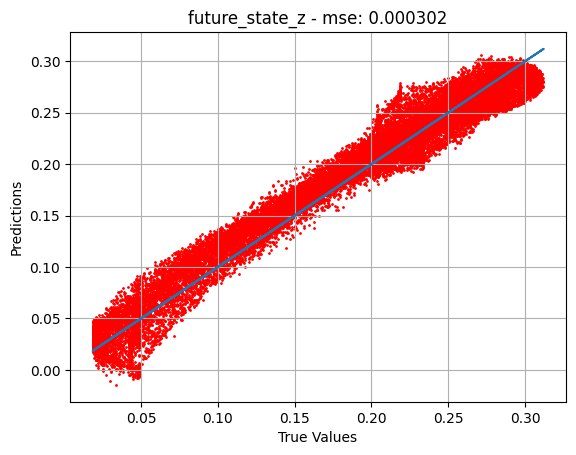

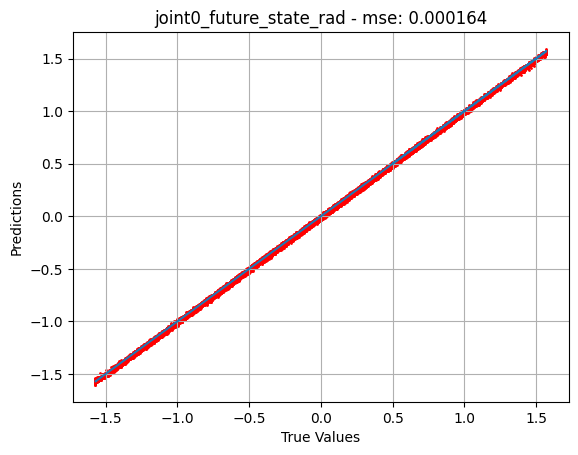

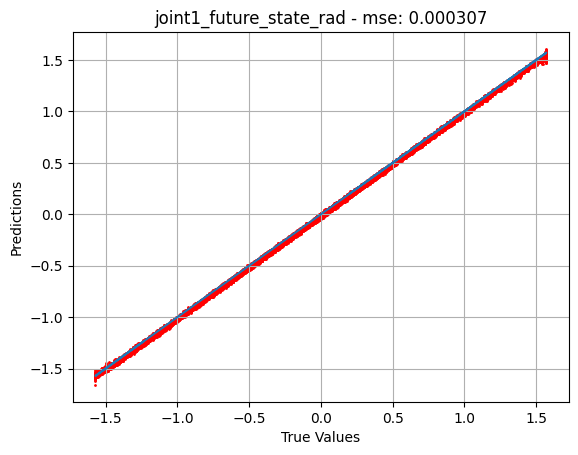

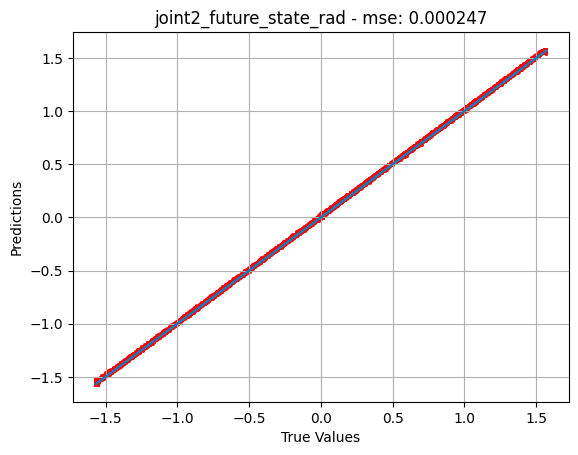

In [54]:
## Finalmente se hace uso de los datos de prueba para la predicción.
# ReLU, ReLU, Linear
test_predictions2 = model2.predict(X_test_scaled)
df_test_predictions2 = pd.DataFrame(test_predictions2)
df_test_predictions2.columns = y_test.columns
plot_pred_vs_test(y_test, df_test_predictions2)

750/750 [==============================] - 1s 835us/step


,Perception,Max.,Min.,Mse,Mse perc.
0,future_state_x,0.185844,-0.185979,0.003103,0.834489
1,future_state_y,0.000035,-0.000089,0.000000,0.311399
2,future_state_z,0.312063,0.018482,0.005438,1.852392
3,joint0_future_state_rad,1.570902,-1.570961,0.072606,2.310924
4,joint1_future_state_rad,1.570797,-1.570798,0.069983,2.227638
5,joint2_future_state_rad,1.570797,-1.570798,0.066270,2.109443


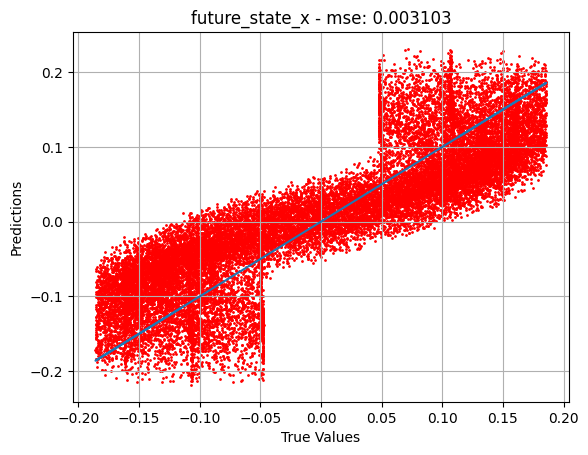

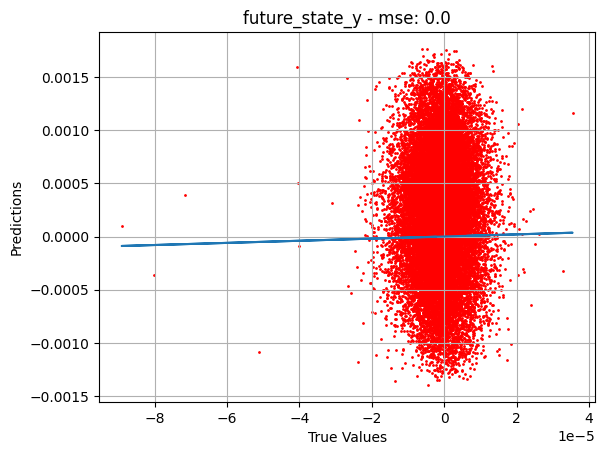

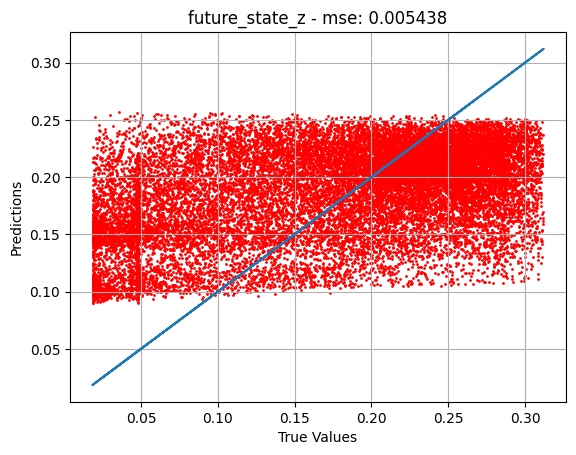

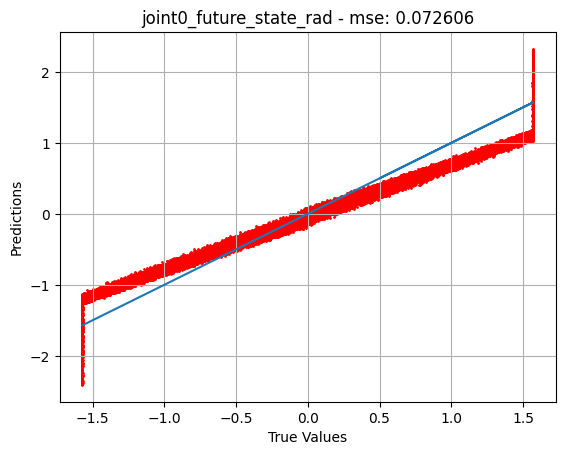

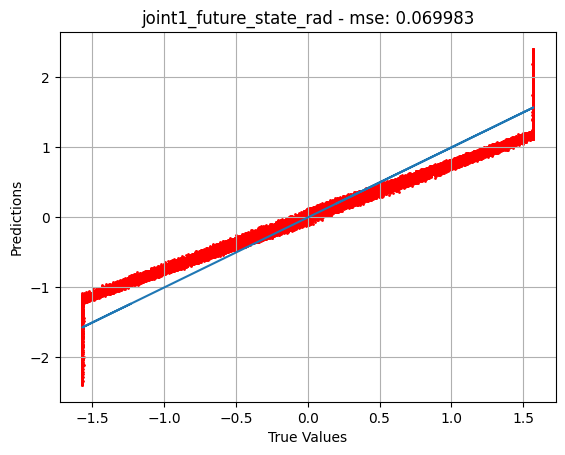

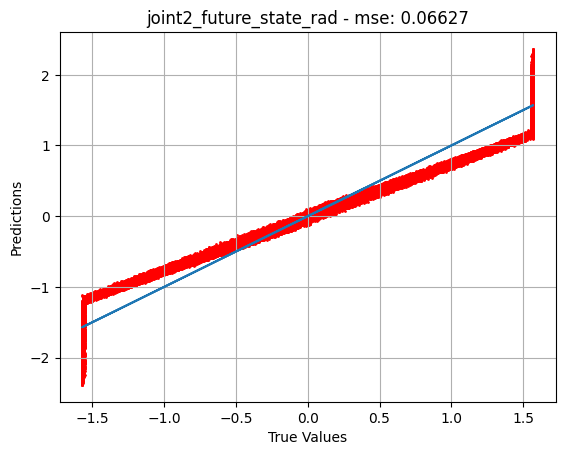

In [56]:
## Finalmente se hace uso de los datos de prueba para la predicción.
# Linear, Linear, Linear
test_predictions2 = model2.predict(X_test_scaled)
df_test_predictions2 = pd.DataFrame(test_predictions2)
df_test_predictions2.columns = y_test.columns
plot_pred_vs_test(y_test, df_test_predictions2)

### Comparacion de modelos

In [ ]:
loaded = load_model('C:\\Users\\carlo\\OneDrive\\Imágenes\\Documentos\\GitHub\\EMERGE\\Morphology\\Multimodular\\models\\2023_15_11\\model_modular03_2023_15_11.keras')

219/219 [==============================] - 0s 798us/step


,Perception,Max.,Min.,Mse,Mse perc.
0,future_state_x,0.185400,-0.184421,0.000030,0.008182
1,future_state_y,0.000029,-0.000044,0.000001,1.041490
2,future_state_z,0.312243,0.020542,0.000041,0.013912
3,joint0_future_state_rad,1.570797,-1.570798,0.000098,0.003132
4,joint1_future_state_rad,1.570797,-1.570797,0.000101,0.003224
5,joint2_future_state_rad,1.570797,-1.570797,0.000105,0.003338


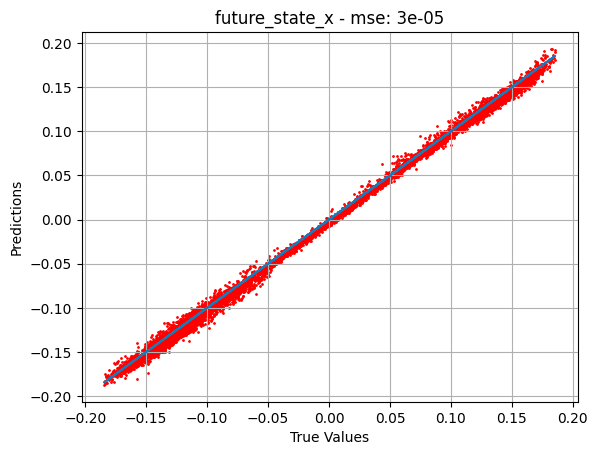

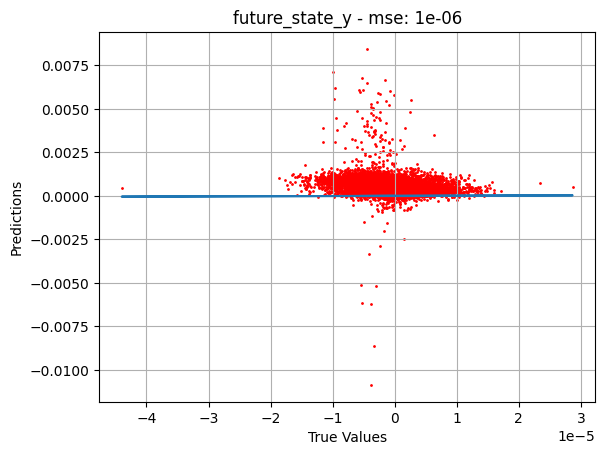

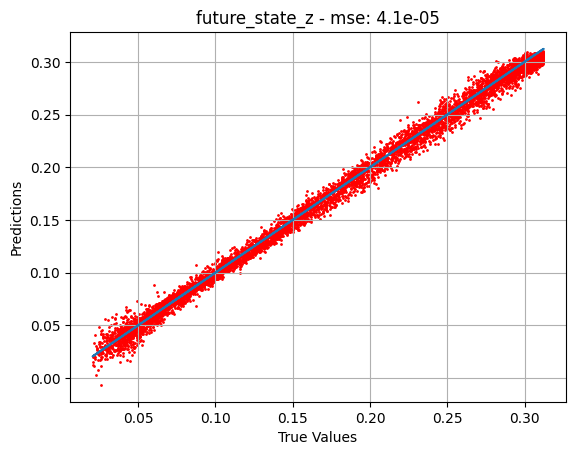

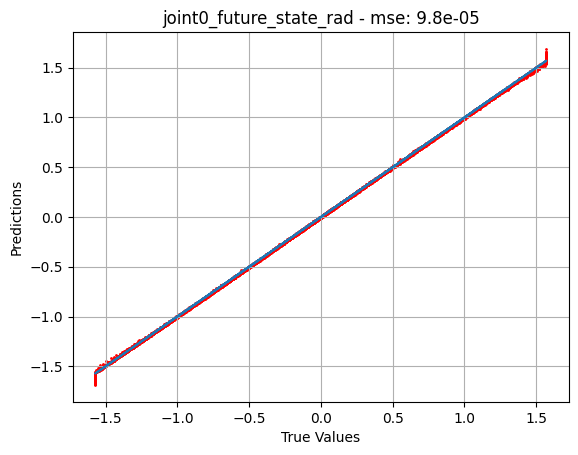

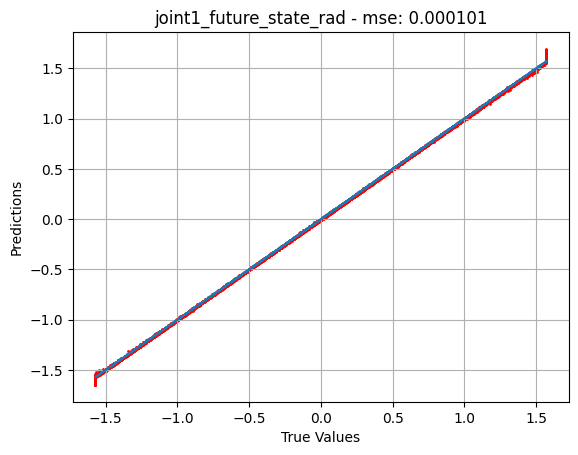

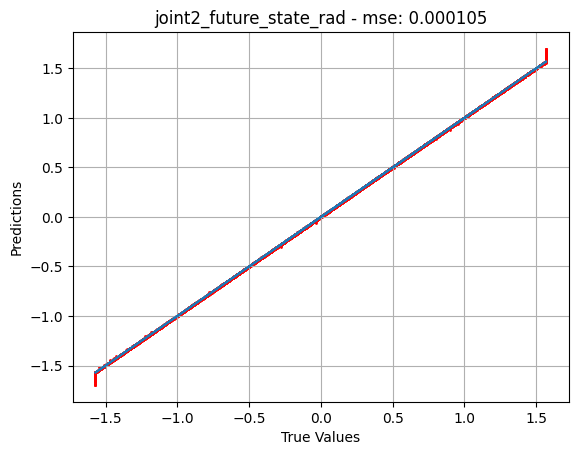

In [ ]:
## Finalmente se hace uso de los datos de prueba para la predicción.
loaded_test_predictions = loaded.predict(X_test_scaled)
loaded_df_test_predictions = pd.DataFrame(loaded_test_predictions)
loaded_df_test_predictions.columns = y_test.columns
plot_pred_vs_test(y_test, loaded_df_test_predictions)

### Revision de datos

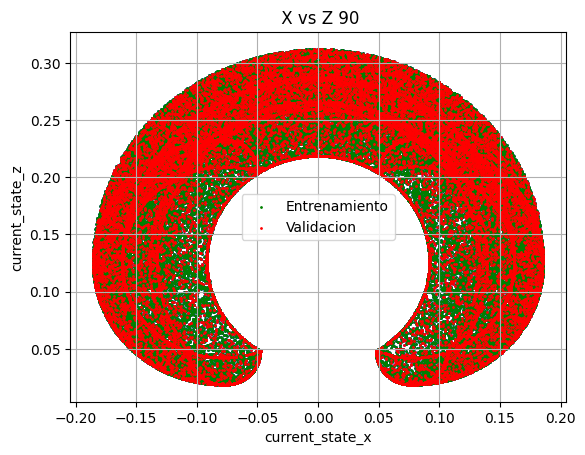

In [62]:
columns = X_train.columns.tolist()
plt.figure()
plt.scatter(X.iloc[:,0],X.iloc[:,2], s=1, color='blue')
plt.scatter(X_train.iloc[:,0],X_train.iloc[:,2], s=1, color='green', label='Entrenamiento')
plt.scatter(X_test.iloc[:,0],X_test.iloc[:,2], s=1, color='red', label='Validacion')
plt.title(" X vs Z 90")
plt.ylabel(columns[2])
plt.xlabel(columns[0])
plt.legend()
plt.grid()

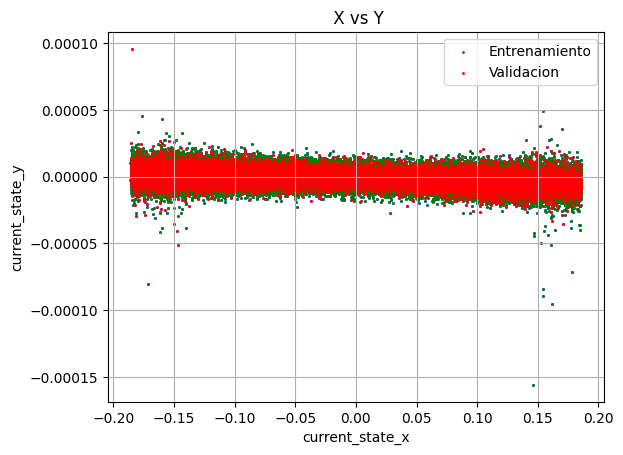

In [11]:
columns = X_train.columns.tolist()
plt.figure()
plt.scatter(X.iloc[:,0],X.iloc[:,1], s=1, color='blue')
plt.scatter(X_train.iloc[:,0],X_train.iloc[:,1], s=1, color='green', label='Entrenamiento')
plt.scatter(X_test.iloc[:,0],X_test.iloc[:,1], s=1, color='red', label='Validacion')
plt.title(" X vs Y")
plt.ylabel(columns[1])
plt.xlabel(columns[0])
plt.legend()
plt.grid()

#### Grafica 3D

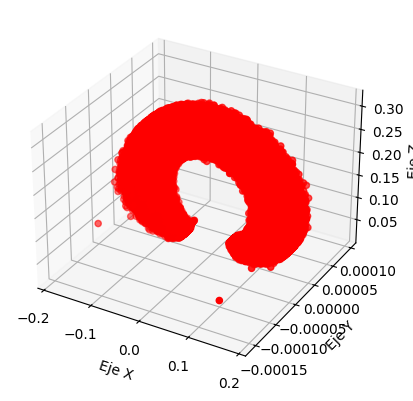

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Datos de ejemplo
x = X.iloc[:,0]
y = X.iloc[:,1]
z = X.iloc[:,2]

# Crear una figura en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar puntos en 3D
ax.scatter(x, y, z, c='r', marker='o')

# Etiquetas de ejes
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

# Mostrar la gráfica en 3D
plt.show()

#### Combinaciones de posiciones e incrementos

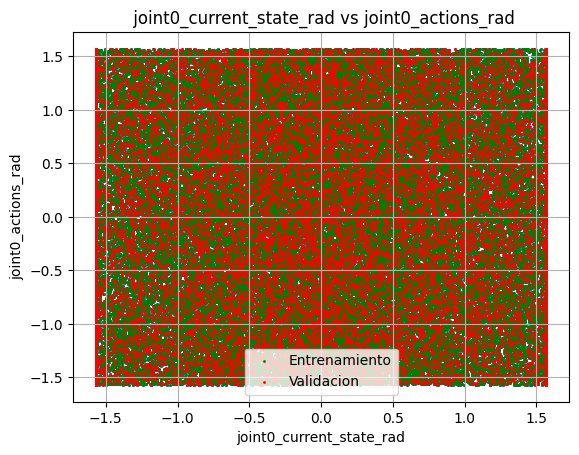

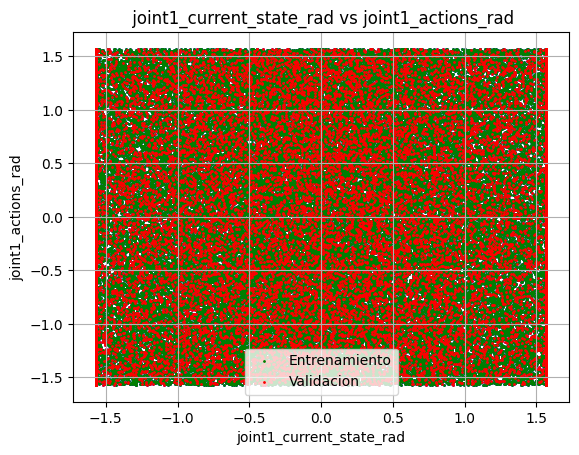

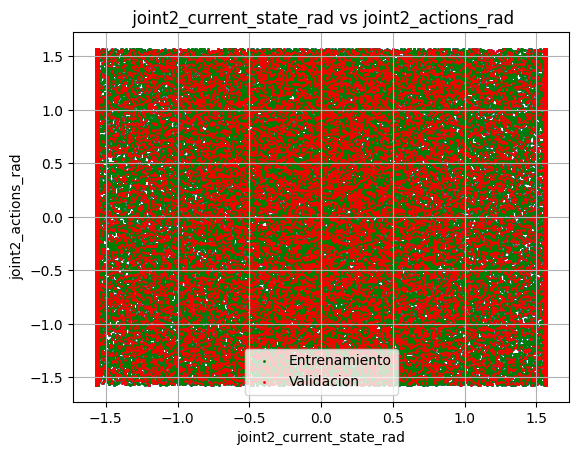

In [13]:
columns = X_train.columns.tolist()
joints_col = []
for col in columns:
    if "joint" in col:
        joints_col.append(col)
joints_col
joints_n = len(joints_col)//2
for joint in range(joints_n):
    plt.figure()
    state_col = 3 + joint
    act_col = 3 + joint + joints_n
    plt.scatter(X.iloc[:,state_col],X.iloc[:,act_col], s=1, color='blue')
    plt.scatter(X_train.iloc[:,state_col],X_train.iloc[:,act_col], s=1, color='green', label='Entrenamiento')
    plt.scatter(X_test.iloc[:,state_col],X_test.iloc[:,act_col], s=1, color='red', label='Validacion')
    plt.title(f" {columns[state_col]} vs {columns[act_col]}")
    plt.ylabel(columns[act_col])
    plt.xlabel(columns[state_col])
    plt.legend()
    plt.grid()

### Temp

In [37]:
neurons = 18
epochs_f = 40
b_s = 32

# Activacion
activation_f = 'linear'
#activation_f = 'sigmoid'
#activation_f = 'tanh'
#activation_f = 'ReLU'

# Optimizador
#optim = SDG(learning_rate=0.001)
#optim = RMSprop(learning_rate=0.001)
optim = Adam(learning_rate=0.001)

# Funcion de perdida
#loss_f = 'mean_squared_error'
#loss_f = 'mean_absolute_error'
loss_f = Huber()

In [38]:
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=9, input_dim=9))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=neurons, activation=activation_f))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=6, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=optim, loss=loss_f)

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train, epochs=epochs_f, batch_size=b_s, validation_split=0.2)

Epoch 1/40
2400/2400 [==============================] - 3s 1ms/step - loss: 0.0354 - val_loss: 0.0182
Epoch 2/40
2400/2400 [==============================] - 3s 1ms/step - loss: 0.0182 - val_loss: 0.0181
Epoch 3/40
2400/2400 [==============================] - 3s 1ms/step - loss: 0.0181 - val_loss: 0.0181
Epoch 4/40
2400/2400 [==============================] - 3s 1ms/step - loss: 0.0181 - val_loss: 0.0180
Epoch 5/40
2400/2400 [==============================] - 3s 1ms/step - loss: 0.0181 - val_loss: 0.0180
Epoch 6/40
2400/2400 [==============================] - 3s 1ms/step - loss: 0.0180 - val_loss: 0.0183
Epoch 7/40
2400/2400 [==============================] - 3s 1ms/step - loss: 0.0180 - val_loss: 0.0179
Epoch 8/40
2400/2400 [==============================] - 3s 1ms/step - loss: 0.0180 - val_loss: 0.0183
Epoch 9/40
2400/2400 [==============================] - 3s 1ms/step - loss: 0.0180 - val_loss: 0.0180
Epoch 10/40
2400/2400 [==============================] - 4s 1ms/step - loss: 0.018

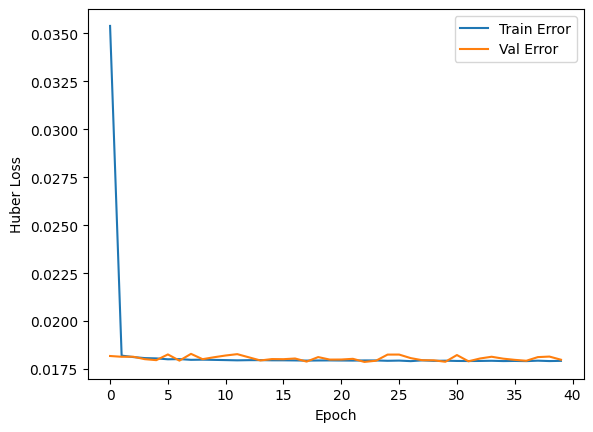

In [39]:
plot_history(history, "Huber")

750/750 [==============================] - 1s 795us/step


,Perception,Max.,Min.,Mse,Mse perc.
0,future_state_x,0.185844,-0.185979,0.003050,0.820327
1,future_state_y,0.000035,-0.000089,0.000001,0.660248
2,future_state_z,0.312063,0.018482,0.005299,1.804885
3,joint0_future_state_rad,1.570902,-1.570961,0.070500,2.243906
4,joint1_future_state_rad,1.570797,-1.570798,0.070139,2.232599
5,joint2_future_state_rad,1.570797,-1.570798,0.066998,2.132622


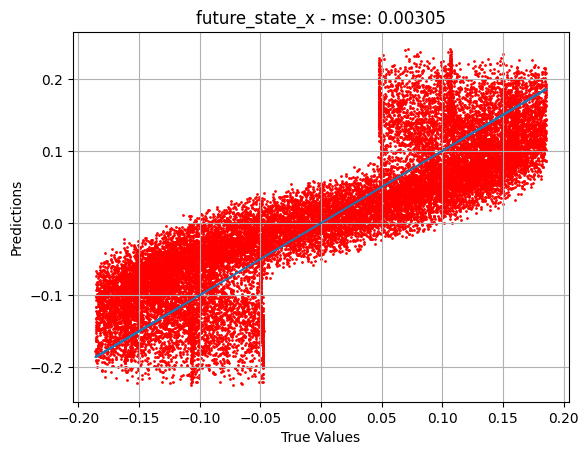

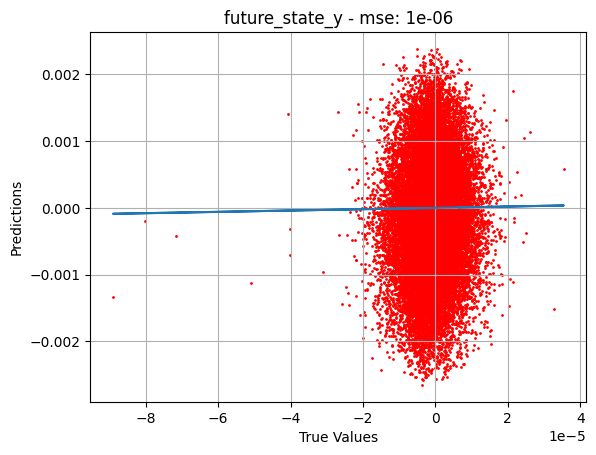

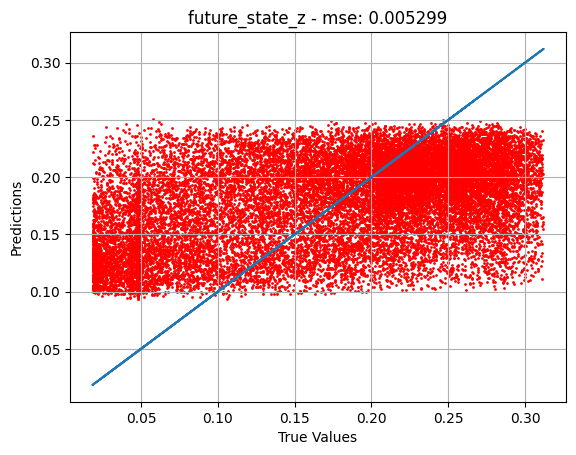

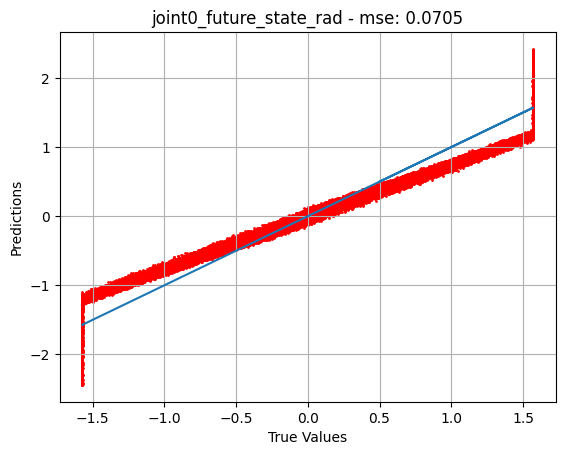

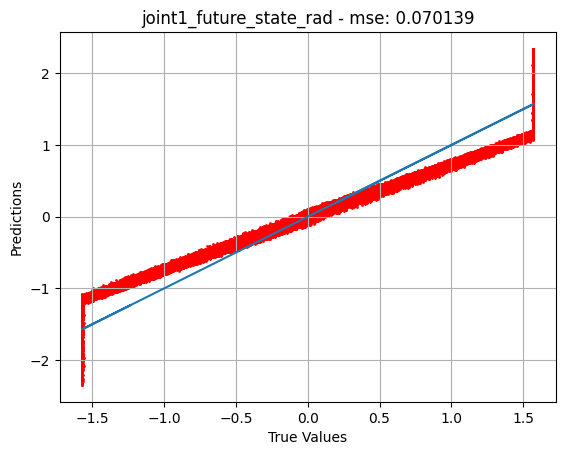

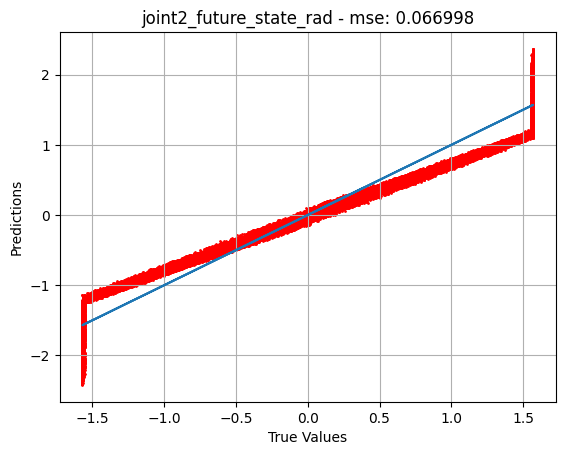

In [40]:
## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
df_test_predictions = pd.DataFrame(test_predictions)
df_test_predictions.columns = y_test.columns
plot_pred_vs_test(y_test, df_test_predictions)